Dataset - https://www.kaggle.com/ted8080/house-prices-and-images-socal?select=socal2

In [1]:
from os.path import isfile, join
import pandas as pd
import numpy as np
import cv2
from utils import *
from sklearn.utils import resample

df = pd.read_csv("data/houses/socal2.csv")
df.head()

,image_id,street,citi,n_citi,bed,bath,sqft,price
0,0,1317 Van Buren Avenue,"Salton City, CA",317,3,2.0,1560,201900
1,1,124 C Street W,"Brawley, CA",48,3,2.0,713,228500
2,2,2304 Clark Road,"Imperial, CA",152,3,1.0,800,273950
3,3,755 Brawley Avenue,"Brawley, CA",48,3,1.0,1082,350000
4,4,2207 R Carrillo Court,"Calexico, CA",55,4,3.0,2547,385100


<AxesSubplot:>

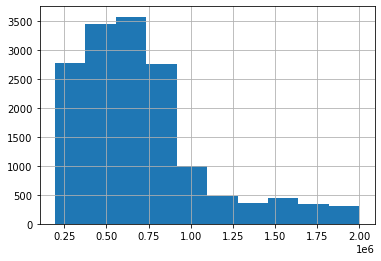

In [2]:
df.price.hist()

In [3]:
def load_dataset(df, images_path="data/houses/images", size=(32,32), gray_scale=False, info=True):
    images = []
    prices = []
    for _,row in df.iterrows():
        img_id = row.image_id
        prices.append(row.price)
        
        img = cv2.imread(join(images_path, f"{img_id}.jpg"))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if gray_scale else cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(cv2.resize(img, size))
    if info:
        print(f"{len(images)} imagens carregadas")
    return np.array(images), np.array(prices)

size = (64,64)
gray_scale = True
images, prices = load_dataset(df, size=size, gray_scale=gray_scale)
if gray_scale:
    _ = plt.gray()

15474 imagens carregadas


<Figure size 432x288 with 0 Axes>

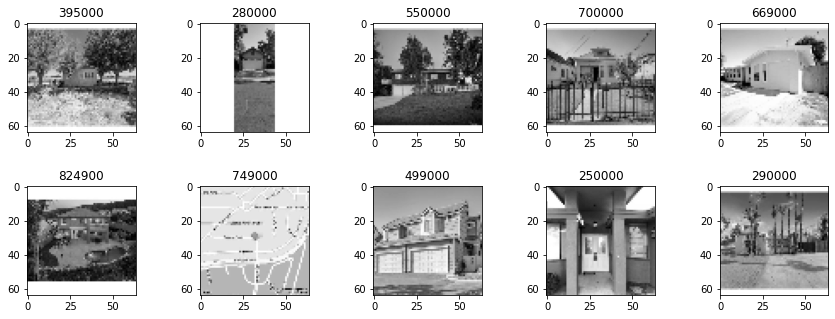

In [4]:
num_samples = 10
samples = resample(images, prices, n_samples=num_samples, replace=False)

plot_images(samples[0], labels=samples[1], rows=2)

In [5]:
from sklearn.model_selection import train_test_split

X = images_to_2d(images)
Y = prices

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [6]:
from models import PPCA
# ppca = PPCA(2)
# ppca.fit(X_train)

# z = ppca.project(X_train)
# x = ppca.reconstruct(z)

In [7]:
# from sklearn.utils import resample

# num_samples = 4
# samples = resample(X_test, Y_test, n_samples=num_samples, replace=False)

# fig = plt.figure(figsize=(15,10))
# for n, (img, label) in enumerate(zip(samples[0], samples[1])):
#     reconstruct = ppca.reconstruct(ppca.project(img))
    
#     plt.subplot(2, num_samples, n+1)
#     plt.title(label)
#     plt.imshow(vector_to_image(img, size))
    
#     plt.subplot(2, num_samples, n+num_samples+1)
#     plt.title("Reconstruído")
#     plt.imshow(vector_to_image(reconstruct, size))
    
# plt.show()

In [8]:
from sklearn.metrics import mean_squared_error
from models import BayesianLinearRegression
# model = BayesianLinearRegression()
# model.fit(z, Y_train, alpha=1, beta=1)

# predictions = model.predict(ppca.project(X_test))

# baysian_regession_rmse = mean_squared_error(Y_test, predictions, squared=False)
# print(f"Raiz do erro quadrado médio: {baysian_regession_rmse}")
# print(f"NLPD: {model.nlpd(ppca.project(X_test), Y_test)}")

In [9]:
# data = df[["bed", "bath", "sqft", "price"]].values
# XX = data[:,:-1]
# YY = data[:,-1]

# XX_train, XX_test, YY_train, YY_test = train_test_split(XX,YY, test_size=0.2, random_state=42)

# model = BayesianLinearRegression()
# model.fit(XX_train, YY_train, alpha=100, beta=100)

# predictions = model.predict(XX_test)

# baseline_bayesian_rmse = mean_squared_error(YY_test, predictions, squared=False)
# print(f"Raiz do erro quadrado médio: {baseline_bayesian_rmse}")
# print(f"NLPD: {model.nlpd(XX_test, YY_test)}")

In [ ]:
import GPy
import GPyOpt
from sklearn.gaussian_process.kernels import RBF

basis_functions = [
                    identity, 
                    add_bias_parameter, 
#                     RBF()
                  ]
basis_functions_names = [
                        "identidade", 
                        "termo independente", 
#                         "rbf"
                        ]

def optimizable_function_rmse(params):
    n_components = int(params[0,0])
    alpha = params[0,1]
    beta = params[0,2]
    bf = basis_functions[int(params[0,3])]
    
    ppca = PPCA(n_components)
    ppca.fit(X_train)
    
    model = BayesianLinearRegression()
    model.fit(ppca.project(X_train), Y_train, alpha=alpha, beta=beta)

    predictions = model.predict(ppca.project(X_test))

    return mean_squared_error(Y_test, predictions, squared=False)

def optimizable_function_nlpd(params):
    values = []
    for p in params:
        img_size = int(p[0])
        gray_scale = int(p[1]) == 1
        n_components = int(p[2])
        alpha = p[3]
        beta = p[4]
        bf = basis_functions[int(p[5])]

        images, Y = load_dataset(df, size=(img_size,img_size), gray_scale=gray_scale, info=False)
        X = images_to_2d(images)
        X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)
        
        ppca = PPCA(n_components)
        ppca_folder = f"size={img_size},gray_scale={gray_scale},n_components={n_components}"
        print(f"Calculando NLPD para combinação: {ppca_folder}")
        try:
            ppca.load(ppca_folder)
            print(f"PPCA já treinado.")
        except Exception as e:
            print(f"PPCA não treinado previamente. Iniciando treinamento...")
            ppca.fit(X_train)
            ppca.save(ppca_folder)
            
        model = None
        try:
            model = BayesianLinearRegression(basis_function=bf)
            model.fit(ppca.project(X_train), Y_train, alpha=alpha, beta=beta)
        except Exception as e:
            print(params)
            print(X_train.shape, ppca.M_inv.shape, ppca.W.shape)
            raise e

        values.append(model.nlpd(ppca.project(X_test), Y_test))
        print(f"NLPD calculado: {values[-1]}\n\n")
        
        del model
        del ppca
    
    return np.array(values)

bounds = [
    {"name": "img_size", 'type': 'discrete', "domain": [16,32,64,128]},
    {"name": "gray_scale", "type": "categorical", "domain": (0,1)},
    {"name": "n_components", 'type': 'discrete', "domain": [2,10, 50, 100, 200, 300, 500, 1000]},
    {"name": "alpha", "type": "continuous", "domain": (1, 100)},
    {"name": "beta", "type": "continuous", "domain": (1, 100)},
    {"name": "basis function", "type": "categorical", "domain": np.arange(len(basis_functions))}
]

optimizer = GPyOpt.methods.BayesianOptimization(optimizable_function_nlpd, bounds, verbosity=True,
                                               initial_design_type='latin',
                                               acquisition_type='MPI')
optimizer.run_optimization(50)# max itter

Calculando NLPD para combinação: size=64,gray_scale=True,n_components=300
PPCA não treinado previamente. Iniciando treinamento...
NLPD calculado: 15941806609722.89


Calculando NLPD para combinação: size=32,gray_scale=False,n_components=300
PPCA já treinado.
NLPD calculado: 4884154107335.492


Calculando NLPD para combinação: size=32,gray_scale=False,n_components=200
PPCA não treinado previamente. Iniciando treinamento...
NLPD calculado: 2138178600324.733


Calculando NLPD para combinação: size=16,gray_scale=True,n_components=100
PPCA não treinado previamente. Iniciando treinamento...
NLPD calculado: 3489035484698.011


Calculando NLPD para combinação: size=64,gray_scale=False,n_components=10
PPCA já treinado.
NLPD calculado: 29070383890462.82


Calculando NLPD para combinação: size=16,gray_scale=True,n_components=100
PPCA já treinado.
NLPD calculado: 1731722450305.3767


Calculando NLPD para combinação: size=16,gray_scale=True,n_components=100
PPCA já treinado.
NLPD calculado: 1186610

In [ ]:
params = optimizer.x_opt
img_size = int(p[0])
gray_scale = int(p[1]) == 1
n_components = int(p[2])
alpha = p[3]
beta = p[4]
bf = basis_functions_names[int(p[5])]
    
print("Resultados da otimização:")
print(f"""Métrica otimizada: {optimizer.fx_opt}
tamanho da imagem: {img_size}x{img_size}
escala de cinza: {gray_scale}
espaço latente: {n_components}
alpha: {alpha}
beta: {beta}
função de base: {bf}""")